<a href="https://colab.research.google.com/github/Gilf4/Yadro_testTask/blob/main/lab3_ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Смирнов Егор 23-ИИ Лабораторная работа: 3.  
Вариант:9 (ResNet152V2).   
Третья часть лабораторной. Дообучения ResNet152.   

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.resnet import preprocess_input

In [ ]:
dataset_hh, info_hh = tfds.load(
    'horses_or_humans',
    split='train + test',
    as_supervised=True,
    with_info=True
)

dataset_cd, info_cd = tfds.load(
    'cats_vs_dogs',
    split=f'train[:{len(dataset_hh)}]',
    as_supervised=True,
    with_info=True
)

In [3]:
print(f"Horses vs Humans: {len(dataset_hh)}")
print(f"Cats vs Dogs: {len(dataset_cd)}")

Horses vs Humans: 1283
Cats vs Dogs: 1283


In [4]:
IMG_SIZE = (224, 224)

def process_hh(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    return image, label

def process_cd(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = preprocess_input(image)
    return image, label + 2

dataset_hh = dataset_hh.map(process_hh)
dataset_cd = dataset_cd.map(process_cd)

In [5]:
dataset = dataset_hh.concatenate(dataset_cd)
len(dataset)

2566

In [6]:
all_images, all_labels = [], []
for image, label in dataset:
    all_images.append(image.numpy())
    all_labels.append(label.numpy())

all_images = np.array(all_images)
all_labels = np.array(all_labels)

print(all_images.shape, all_labels.shape)

(2566, 224, 224, 3) (2566,)


In [7]:
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    all_images, all_labels,
    test_size=0.15,
    random_state=42,
    stratify=all_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.176,
    random_state=42,
    stratify=y_temp
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (1797, 224, 224, 3), y_train: (1797,)
X_val: (384, 224, 224, 3), y_val: (384,)
X_test: (385, 224, 224, 3), y_test: (385,)


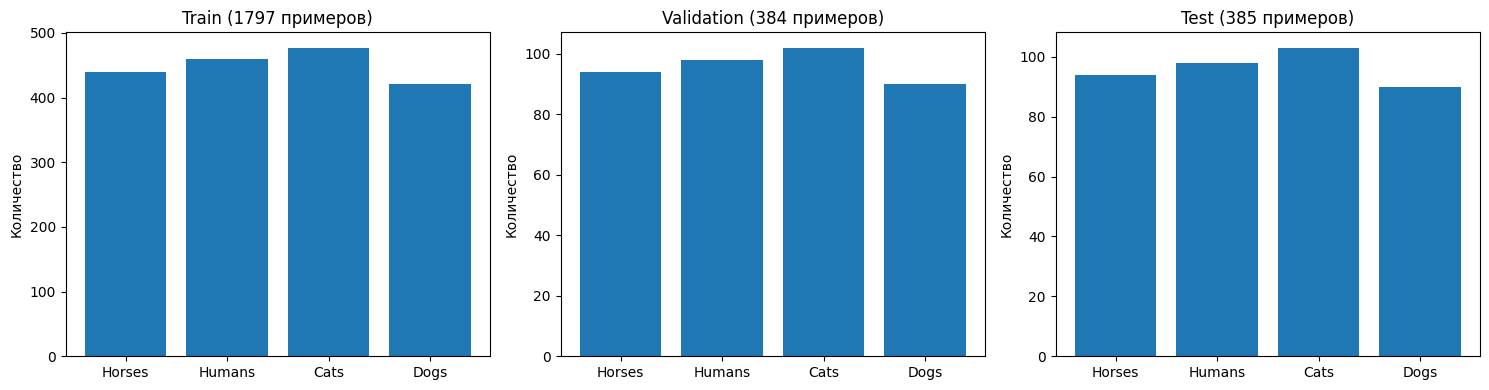

In [8]:

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
datasets = [y_train, y_val, y_test]
titles = ['Train', 'Validation', 'Test']
class_names = ['Horses', 'Humans', 'Cats', 'Dogs']

for i, (y_data, title) in enumerate(zip(datasets, titles)):
    unique, counts = np.unique(y_data, return_counts=True)
    axes[i].bar([class_names[cls] for cls in unique], counts)
    axes[i].set_title(f'{title} ({len(y_data)} примеров)')
    axes[i].set_ylabel('Количество')

plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras import layers, models


In [10]:
NUM_CLASSES = 4

In [11]:

backbone = ResNet152V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

backbone.trainable = False #заморозка ResNet152 слоев

model = models.Sequential([
    # Data augmentation
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomFlip("horizontal"),

    # Backbone
    backbone,

    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),

    #FC
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet152v2 (Functional)        │ (None, 7, 7, 2048)     │    58,331,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,995,662 (236.49 MB)

 Trainable params: 1,219,460 (4.65 MB)

 Non-trainable params: 58,337,280 (222.54 MB)

 Optimizer params: 2,438,922 (9.30 MB)

In [12]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),

    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]


In [13]:
history1 = model.fit(
    x=X_train, y=y_train,
    batch_size=64,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.3776 - loss: 1.6230 - val_accuracy: 0.3073 - val_loss: 7.3247
Epoch 2/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 852ms/step - accuracy: 0.5022 - loss: 1.2393 - val_accuracy: 0.4062 - val_loss: 2.3890
Epoch 3/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 876ms/step - accuracy: 0.5548 - loss: 1.0818 - val_accuracy: 0.4297 - val_loss: 1.7510
Epoch 4/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 25s 859ms/step - accuracy: 0.5614 - loss: 1.0494 - val_accuracy: 0.5104 - val_loss: 1.1514
Epoch 5/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 850ms/step - accuracy: 0.5393 - loss: 1.0422 - val_accuracy: 0.5964 - val_loss: 0.9190
Epoch 6/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 28s 964ms/step - accuracy: 0.5586 - loss: 0.9928 - val_accuracy: 0.6458 - val_loss: 0.7872
Epoch 7/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 635ms/step - accuracy: 0.5858 - loss: 0.9269 - val_accuracy: 0.6224 - val_loss: 0.7649
Epoch 8/20
29/29 ━━━━━━━━━━━━━━━━━━━━ 18s 622ms/step - accuracy: 0.5764 - loss: 0.9353 - val_accurac

In [14]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy*100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - accuracy: 0.6540 - loss: 0.6761
Test accuracy: 64.94%


In [15]:
model.load_weights('best_model.keras')

y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 646ms/step


In [16]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

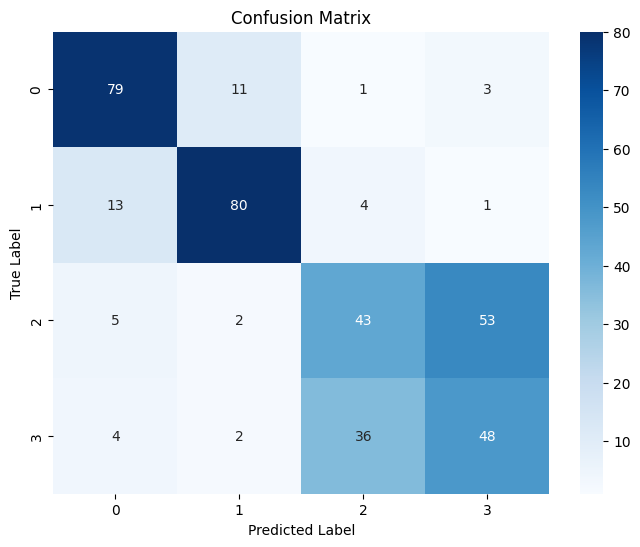

In [17]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [18]:
print(classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(NUM_CLASSES)]))

              precision    recall  f1-score   support

     Class 0       0.78      0.84      0.81        94
     Class 1       0.84      0.82      0.83        98
     Class 2       0.51      0.42      0.46       103
     Class 3       0.46      0.53      0.49        90

    accuracy                           0.65       385
   macro avg       0.65      0.65      0.65       385
weighted avg       0.65      0.65      0.65       385



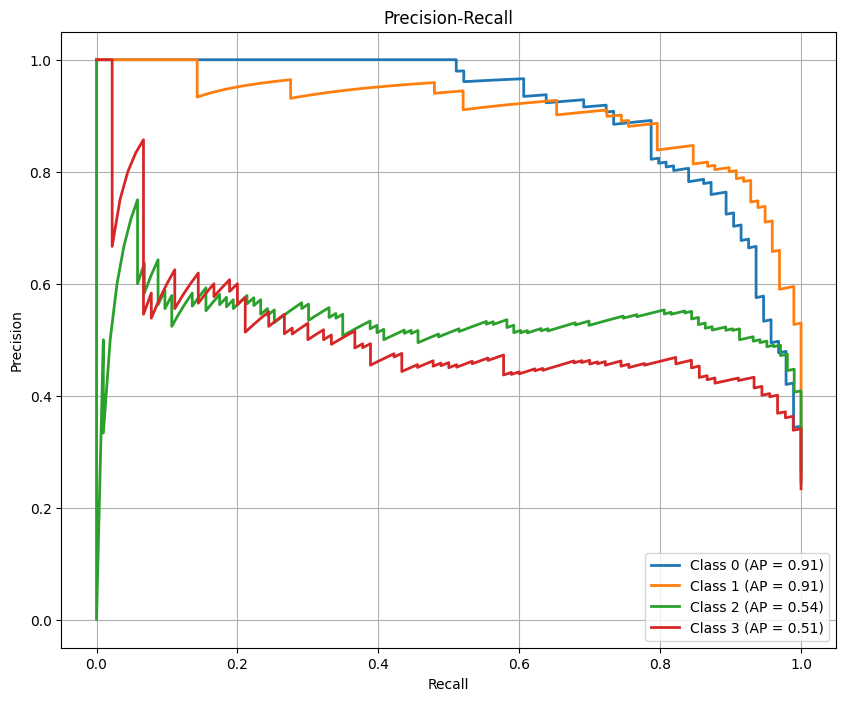

In [19]:
y_test_bin = label_binarize(y_test, classes=range(NUM_CLASSES))

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend()
plt.grid()
plt.show()

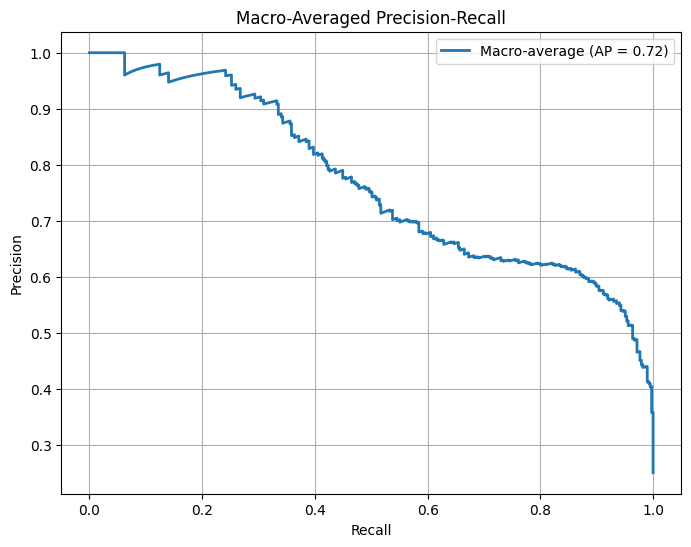

In [20]:
precision_macro, recall_macro, _ = precision_recall_curve(
    y_test_bin.ravel(), y_pred_proba.ravel()
)
avg_precision_macro = average_precision_score(y_test_bin, y_pred_proba, average='macro')

plt.figure(figsize=(8, 6))
plt.plot(recall_macro, precision_macro, lw=2,
         label=f'Macro-average (AP = {avg_precision_macro:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Macro-Averaged Precision-Recall')
plt.legend()
plt.grid()
plt.show()